In [1]:
from modAL.models import ActiveLearner
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
import pandas as pd

%matplotlib inline



# using mushrooms dataset

In [2]:
df = pd.read_csv(r"mushrooms.csv")
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [3]:
df = df.apply(lambda x: pd.factorize(x)[0])
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,1,4,0,0,1,3,1,0,1,10,...,0,6,7,0,2,0,0,8,5,6
8120,1,0,0,0,1,3,1,0,1,10,...,0,6,7,0,1,0,0,8,3,6
8121,1,3,0,0,1,3,1,0,1,1,...,0,6,7,0,2,0,0,8,5,6
8122,0,4,1,0,1,6,0,0,0,8,...,3,0,0,0,0,0,1,4,3,6


In [4]:
X_raw= df.values[:, 1:23]
y_raw= df.values[:, 0]

In [5]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw)

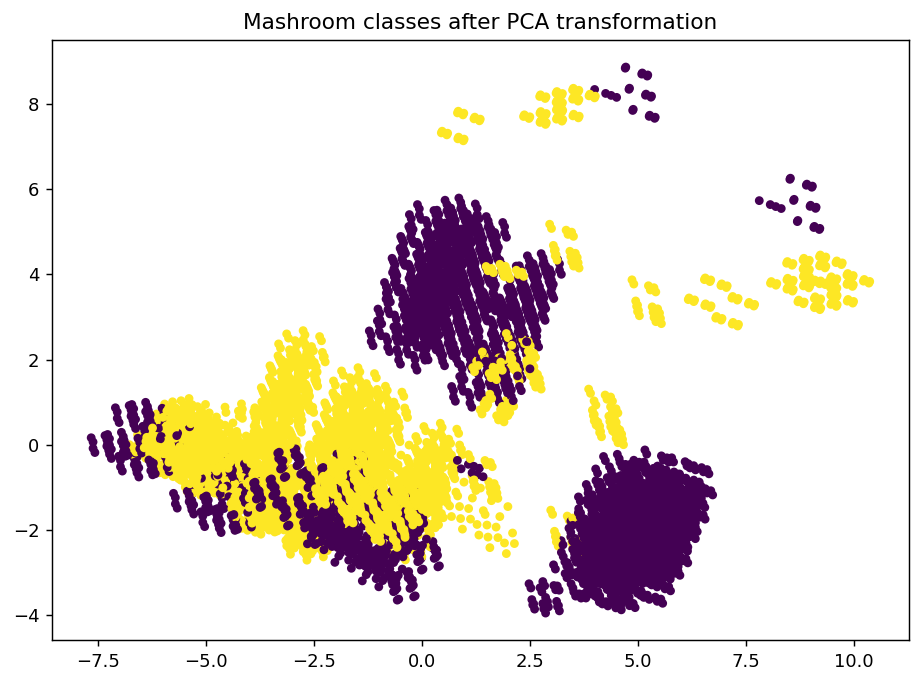

In [12]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed[:, 0], transformed[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=15)
plt.title('Mashroom classes after PCA transformation')
plt.show()

In [8]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

# Applying Active learning using uncertainity sampling strategy 

In [9]:
# Specify our core estimator along with it's active learning model.
DT = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5)
learner = ActiveLearner(estimator=DT, X_training=X_train, y_training=y_train)

In [10]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions


array([0, 0, 0, ..., 1, 0, 1])

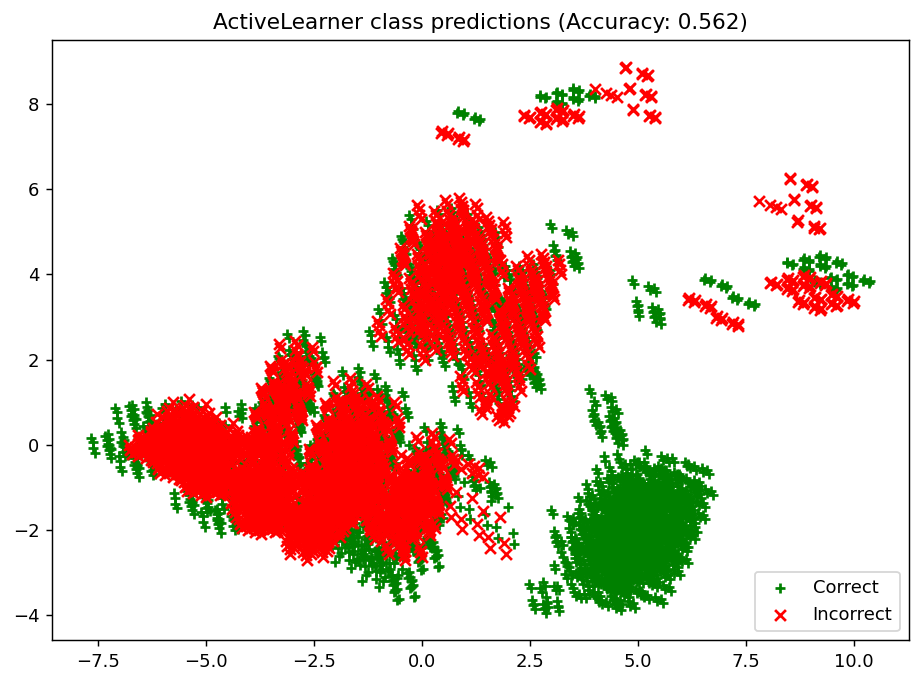

In [11]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [12]:
N_QUERIES = 16
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw, y_raw)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.5623
Accuracy after query 2: 0.7563
Accuracy after query 3: 0.8981
Accuracy after query 4: 0.7784
Accuracy after query 5: 0.9557
Accuracy after query 6: 0.7784
Accuracy after query 7: 0.9202
Accuracy after query 8: 0.9557
Accuracy after query 9: 0.9557
Accuracy after query 10: 0.9557
Accuracy after query 11: 0.8981
Accuracy after query 12: 0.7784
Accuracy after query 13: 0.7784
Accuracy after query 14: 0.9557
Accuracy after query 15: 0.9557
Accuracy after query 16: 0.9852


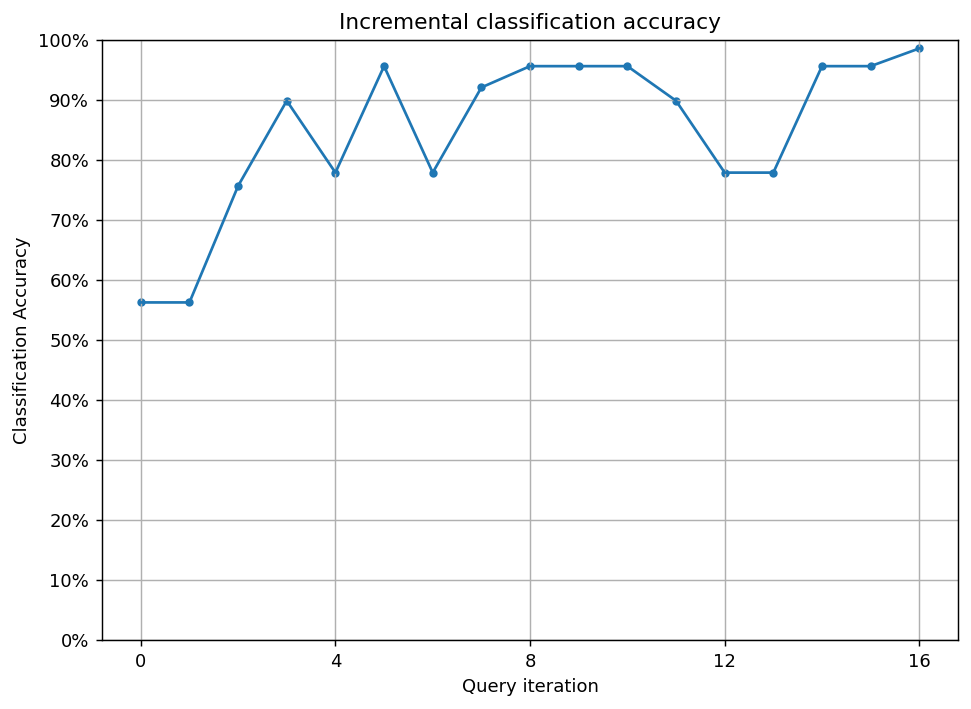

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

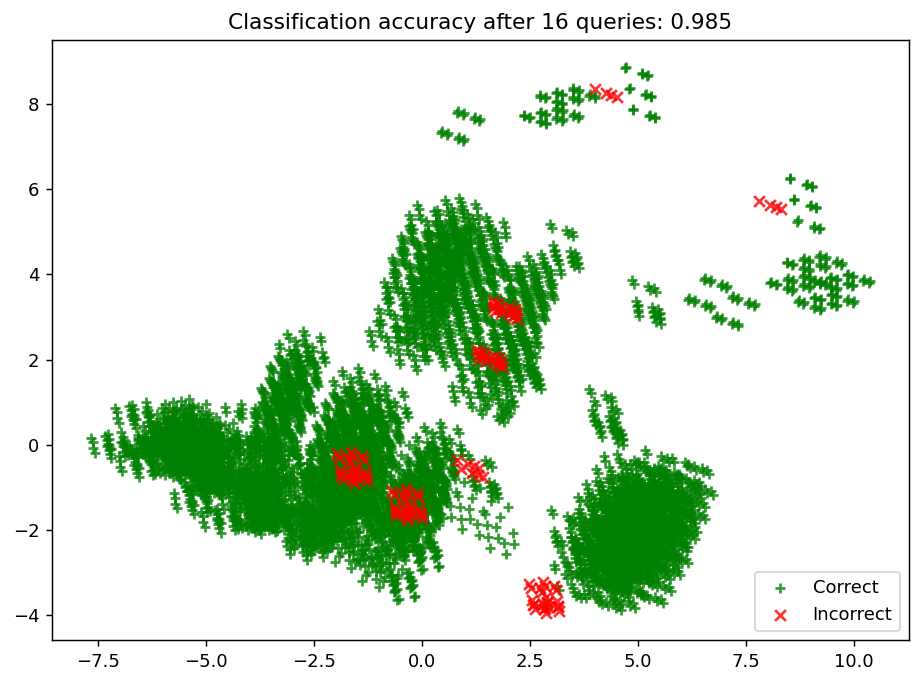

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# Applying Active learning using random sampling strategy 

In [22]:
X_raw1= df.values[:, 1:23]
y_raw1= df.values[:, 0]

In [23]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw1)

In [24]:
# Isolate our examples for our labeled dataset.
n_labeled_examples1 = X_raw1.shape[0]
training_indices1 = np.random.randint(low=0, high=n_labeled_examples1, size=5)

X_train1 = X_raw1[training_indices1]
y_train1 = y_raw1[training_indices1]

# Isolate the non-training examples we'll be querying.
X_pool1 = np.delete(X_raw1, training_indices1, axis=0)
y_pool1 = np.delete(y_raw1, training_indices1, axis=0)

In [25]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool1[query_idx]

learner = ActiveLearner(
    estimator = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5),
    query_strategy=random_sampling,
    X_training=X_train1, y_training=y_train1
)

In [26]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

predictions


array([0, 0, 0, ..., 1, 0, 1])

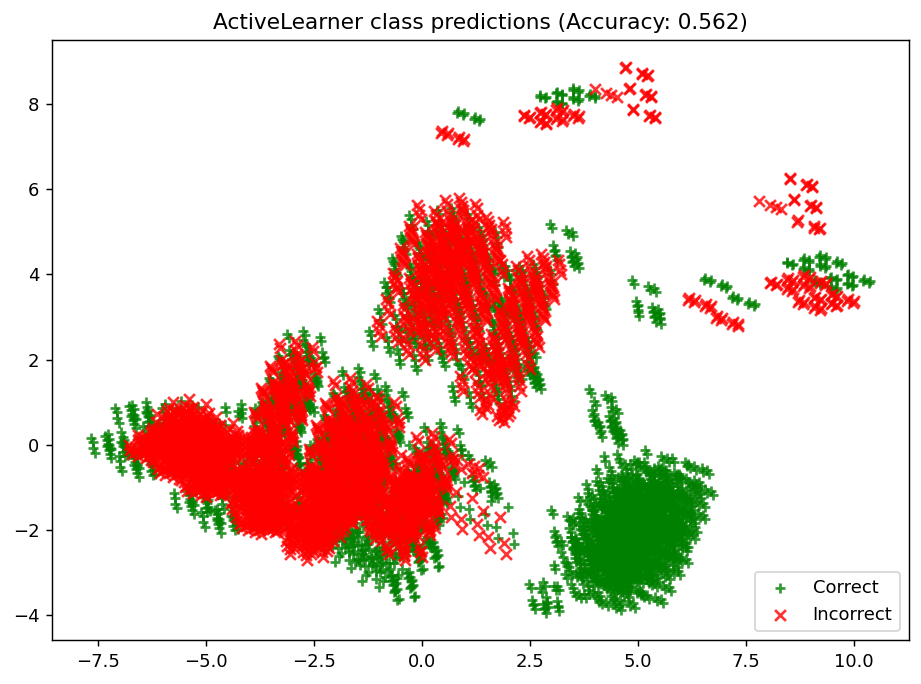

In [27]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw1, y_raw1)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [28]:
N_QUERIES = 16
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool1)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool1[query_index].reshape(1, -1), y_pool1[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool1, y_pool1 = np.delete(X_pool1, query_index, axis=0), np.delete(y_pool1, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw1, y_raw1)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.5623
Accuracy after query 2: 0.9537
Accuracy after query 3: 0.9537
Accuracy after query 4: 0.9557
Accuracy after query 5: 0.8168
Accuracy after query 6: 0.9557
Accuracy after query 7: 0.9360
Accuracy after query 8: 0.9557
Accuracy after query 9: 0.9852
Accuracy after query 10: 0.9852
Accuracy after query 11: 0.9852
Accuracy after query 12: 0.8119
Accuracy after query 13: 0.9852
Accuracy after query 14: 0.7843
Accuracy after query 15: 0.9852
Accuracy after query 16: 0.9852


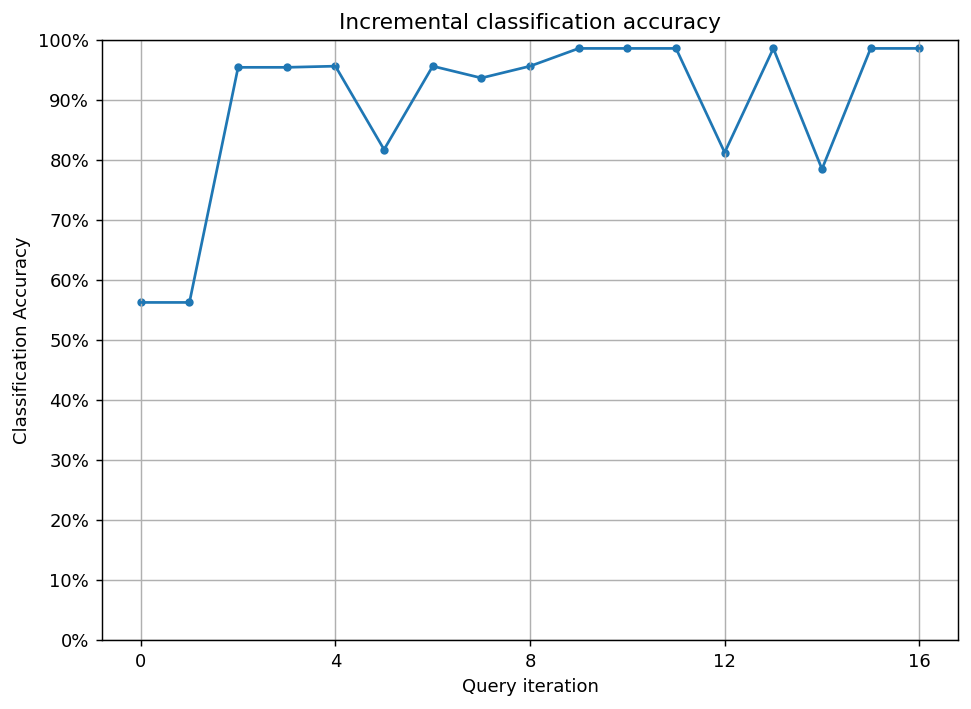

In [29]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

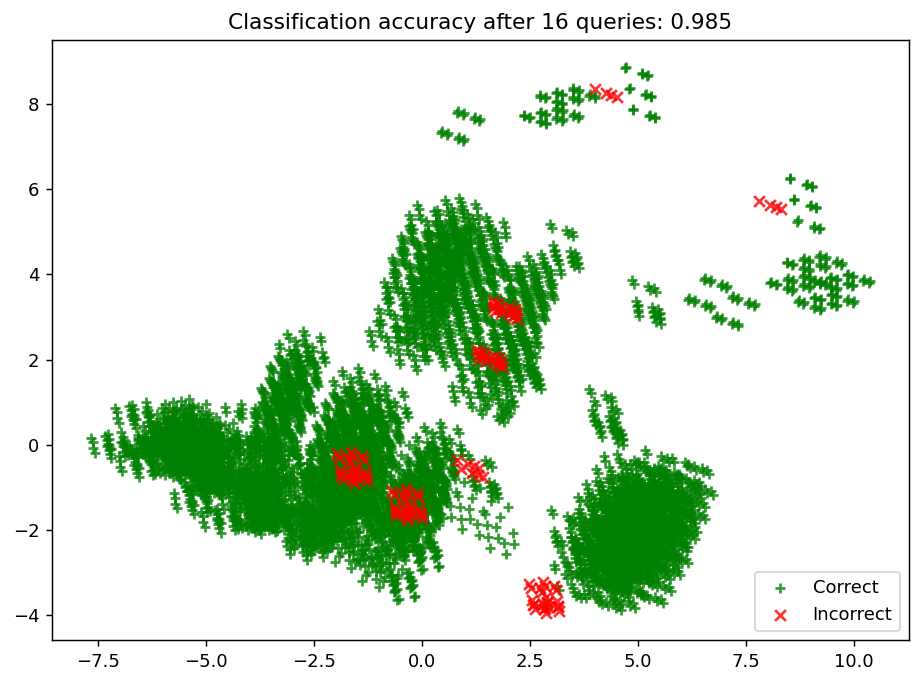

In [30]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# Applying Active learning using entropy sampling strategy 

In [31]:
X_raw2= df.values[:, 1:23]
y_raw2= df.values[:, 0]

In [32]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw2)

In [33]:
# Isolate our examples for our labeled dataset.
n_labeled_examples2 = X_raw2.shape[0]
training_indices2 = np.random.randint(low=0, high=n_labeled_examples2, size=5)

X_train2 = X_raw2[training_indices2]
y_train2 = y_raw2[training_indices2]

# Isolate the non-training examples we'll be querying.
X_pool2 = np.delete(X_raw2, training_indices2, axis=0)
y_pool2 = np.delete(y_raw2, training_indices2, axis=0)

In [34]:
learner = ActiveLearner(
    estimator = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5),
    query_strategy=entropy_sampling,
    X_training=X_train2, y_training=y_train2
)

In [35]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

predictions


array([0, 0, 0, ..., 1, 0, 1])

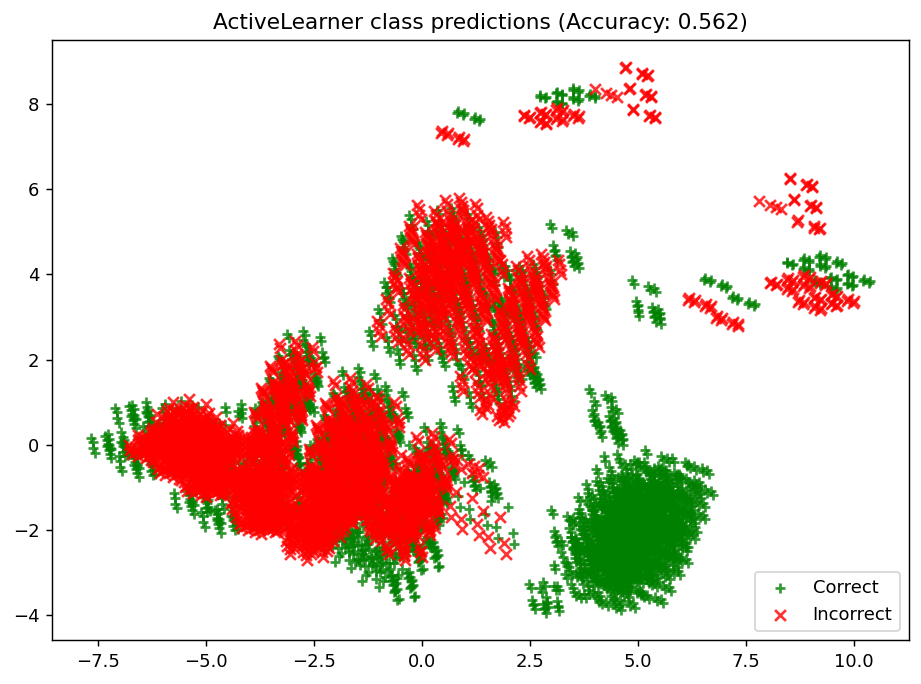

In [36]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw2, y_raw2)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [37]:
N_QUERIES = 17
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool2)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool2[query_index].reshape(1, -1), y_pool2[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool2, y_pool2 = np.delete(X_pool2, query_index, axis=0), np.delete(y_pool2, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw2, y_raw2)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.5623
Accuracy after query 2: 0.7563
Accuracy after query 3: 0.8981
Accuracy after query 4: 0.7784
Accuracy after query 5: 0.9557
Accuracy after query 6: 0.7784
Accuracy after query 7: 0.9202
Accuracy after query 8: 0.9557
Accuracy after query 9: 0.9557
Accuracy after query 10: 0.9557
Accuracy after query 11: 0.8981
Accuracy after query 12: 0.7784
Accuracy after query 13: 0.7784
Accuracy after query 14: 0.9557
Accuracy after query 15: 0.9557
Accuracy after query 16: 0.9852
Accuracy after query 17: 0.9852


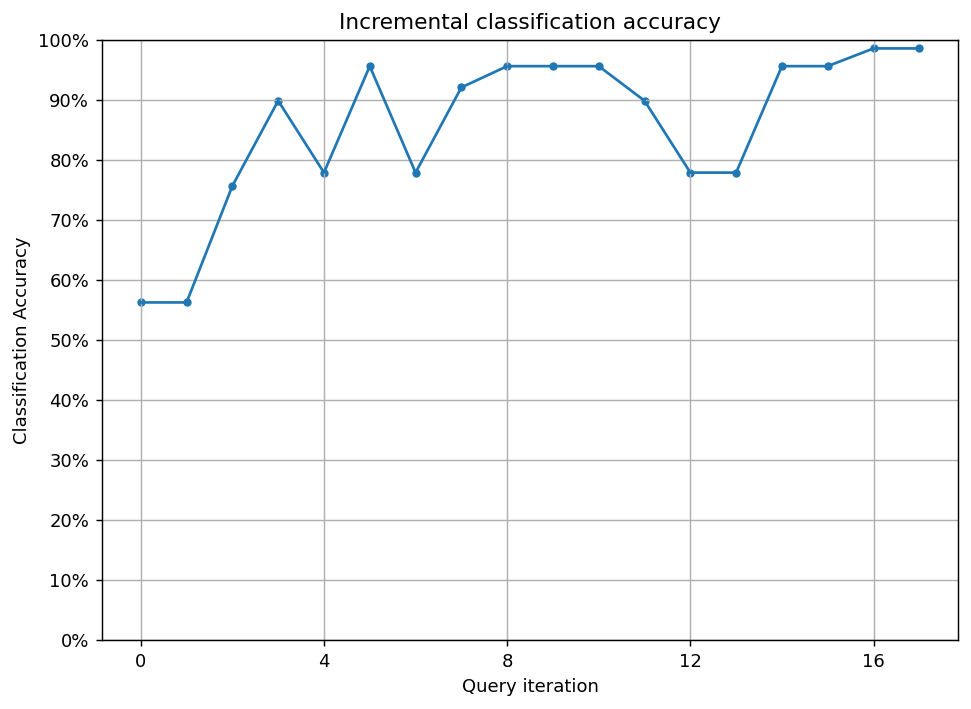

In [38]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

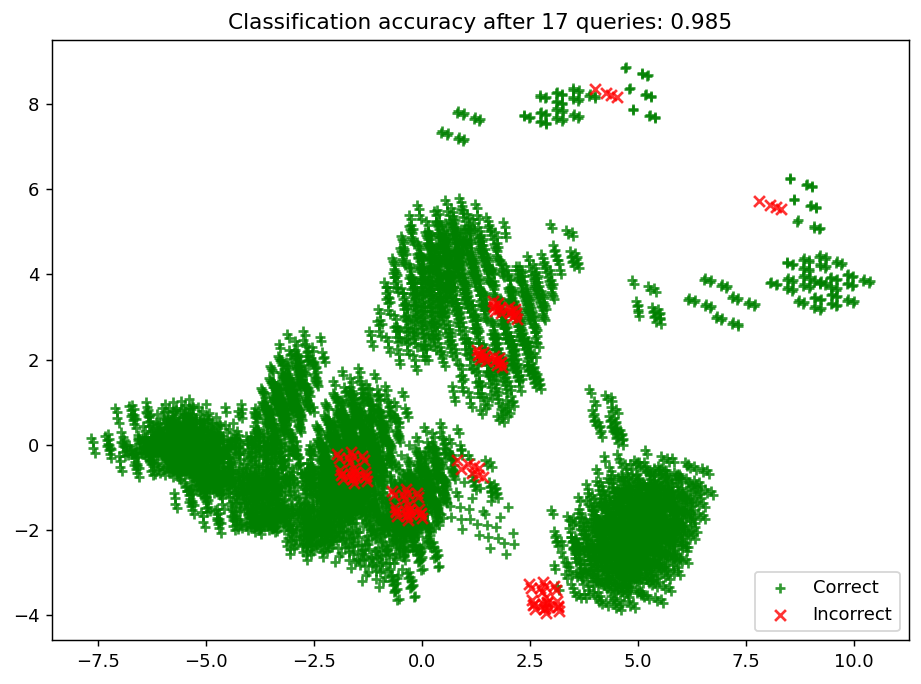

In [39]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

# Applying Active learning using margin sampling strategy 

In [41]:
X_raw3= df.values[:, 1:23]
y_raw3= df.values[:, 0]

In [42]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw3)

In [43]:
# Isolate our examples for our labeled dataset.
n_labeled_examples3 = X_raw3.shape[0]
training_indices3 = np.random.randint(low=0, high=n_labeled_examples3, size=5)

X_train3 = X_raw3[training_indices3]
y_train3 = y_raw3[training_indices3]

# Isolate the non-training examples we'll be querying.
X_pool3 = np.delete(X_raw3, training_indices3, axis=0)
y_pool3 = np.delete(y_raw3, training_indices3, axis=0)

In [44]:
learner = ActiveLearner(
    estimator = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5),
    query_strategy=margin_sampling,
    X_training=X_train3, y_training=y_train3
)

In [45]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

predictions


array([0, 0, 0, ..., 1, 0, 1])

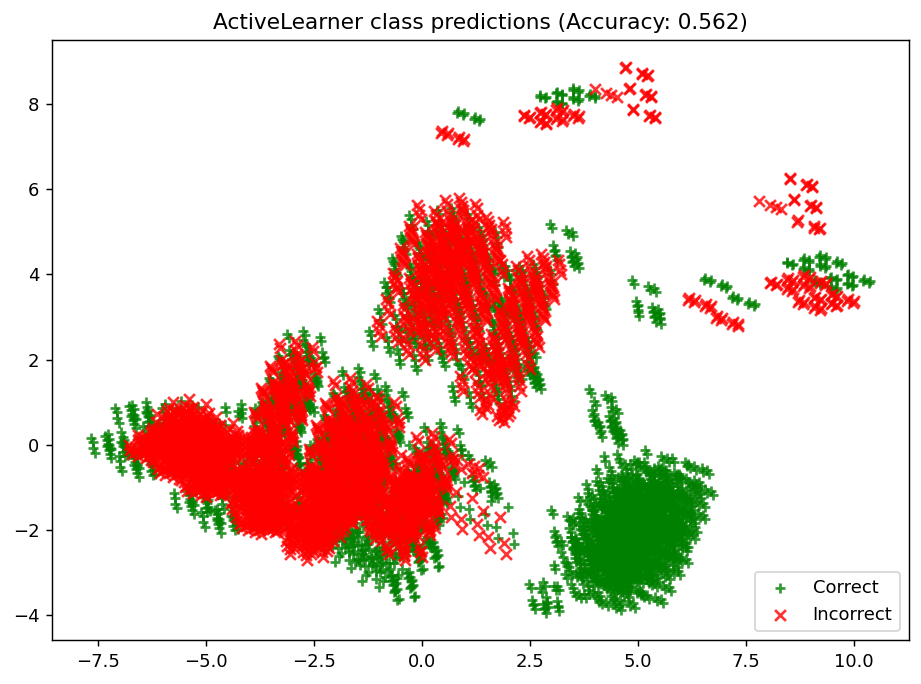

In [46]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw3, y_raw3)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (Accuracy: {score:.3f})".format(score=unqueried_score))
plt.show()

In [47]:
N_QUERIES = 17
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool3)
  
  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool3[query_index].reshape(1, -1), y_pool3[query_index].reshape(1, )
  learner.teach(X=X, y=y)
  
  # Remove the queried instance from the unlabeled pool.
  X_pool3, y_pool3 = np.delete(X_pool3, query_index, axis=0), np.delete(y_pool3, query_index)
  
  # Calculate and report our model's accuracy.
  model_accuracy = learner.score(X_raw3, y_raw3)
  print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
  
  # Save our model's performance for plotting.
  performance_history.append(model_accuracy)

Accuracy after query 1: 0.5623
Accuracy after query 2: 0.7563
Accuracy after query 3: 0.8981
Accuracy after query 4: 0.7784
Accuracy after query 5: 0.9557
Accuracy after query 6: 0.7784
Accuracy after query 7: 0.9202
Accuracy after query 8: 0.9557
Accuracy after query 9: 0.9557
Accuracy after query 10: 0.9557
Accuracy after query 11: 0.8981
Accuracy after query 12: 0.7784
Accuracy after query 13: 0.7784
Accuracy after query 14: 0.9557
Accuracy after query 15: 0.9557
Accuracy after query 16: 0.9852
Accuracy after query 17: 0.9852


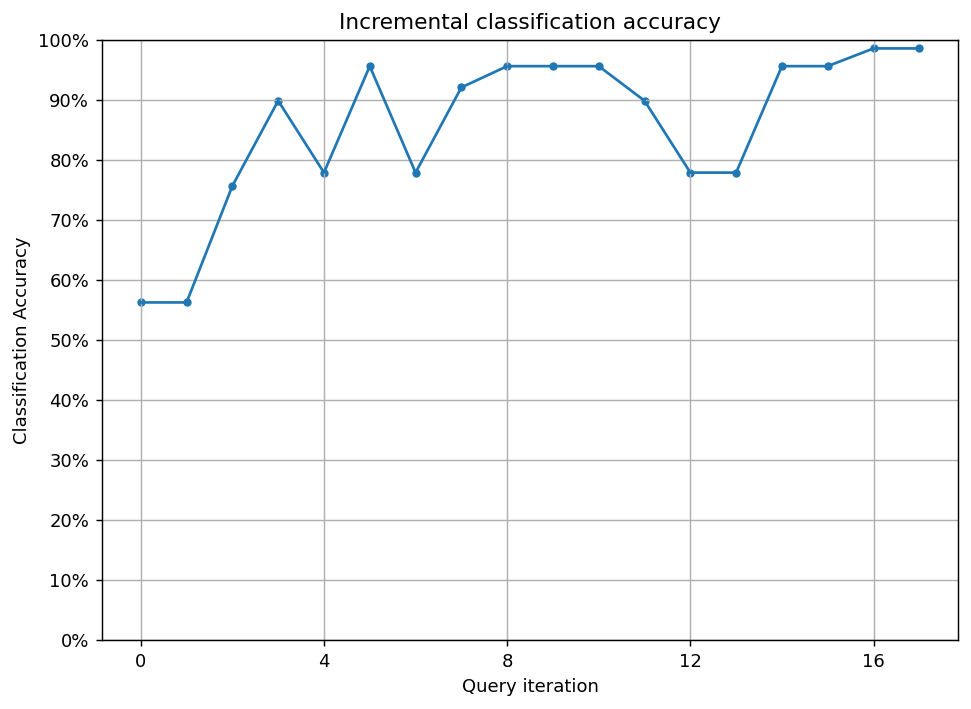

In [48]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

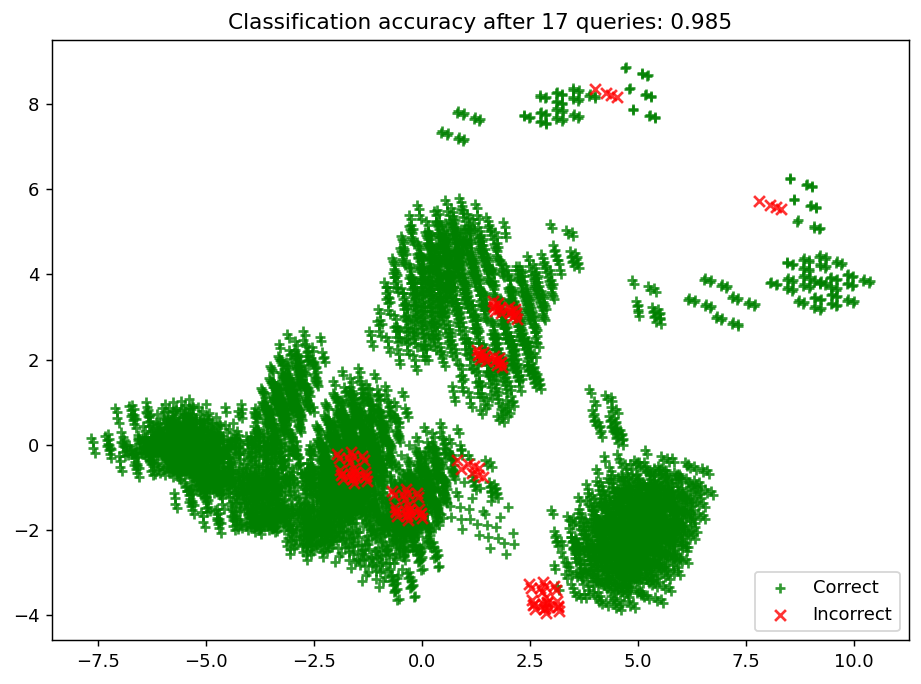

In [49]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification accuracy after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()